<a href="https://colab.research.google.com/github/ImagingDataCommons/IDC-Tutorials/blob/master/notebooks/collections_demos/nlst_clinical_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Working with NLST clinical data in IDC

This notebook is part of the tutorials about [Imaging Data Commons](https://portal.imaging.datacommons.cancer.gov/). You can find the latest version of this tutorial, and other IDC tutorials here: https://github.com/ImagingDataCommons/IDC-Tutorials.

---

National Lung Screening Trial (NLST) [1] is one of the largest collections available in Imaging Data Commons, containing over 10TB of CT images, most of which are accompanied by volumetric segmentations automatically generated using TotalSegmentator, and radiomics features for the segmented regions [2]. As any other collection in IDC, NLST is a public collection available for download.

In addition to the images and image-derived data, IDC hosts a subset of clinical data. This clinical data is searchable, and can be used to form cohorts of patients, or select images of patients with specific characteristics.

In this tutorial you will learn how to access NLST clinical data.

If you have any questions about this tutorial, or a suggestion about a different tutorial, please contact IDC support by sending email to support@canceridc.dev or posting your question on [IDC User forum](https://discourse.canceridc.dev).

If you have never worked with IDC before, we recommend you first complete the getting started tutorial [here](https://github.com/ImagingDataCommons/IDC-Tutorials/blob/master/notebooks/getting_started/part2_searching_basics.ipynb).

--

[1]  National Lung Screening Trial Research Team. (2013). Data from the National Lung Screening Trial (NLST) [Data set]. The Cancer Imaging Archive. https://doi.org/10.7937/TCIA.HMQ8-J677

[2] Thiriveedhi, V. K., Krishnaswamy, D., Clunie, D., & Fedorov, A. (2024). TotalSegmentator segmentations and radiomics features for NCI Imaging Data Commons CT images [Data set]. Zenodo. https://doi.org/10.5281/zenodo.13900142

---
Initial version: Nov 2024


## Prerequisites

The only prerequisite is [`idc-index`](https://github.com/ImagingDataCommons/idc-index) - python package that contains various utilities to simplify access to IDC data.

In [32]:
%%capture
!pip install idc-index

## IDC clinical data index

`idc-index` packages _indices_ - tables containing key metadata describing data available in IDC. The main index that supports API calls related to download and search is installed by default. To support search of the clinical data accompanying IDC images you will need the `clinical_index` table, which helps navigating clinical data accompanying images.

In [5]:
from idc_index import IDCClient

c = IDCClient()

c.fetch_index('clinical_index')

print('Columns avaialable in clinical_index:\n'+'\n'.join(c.clinical_index.keys()))

Columns avaialable in clinical_index:
collection_id
table_name
short_table_name
column
column_label
values


This table is documented in https://idc-index.readthedocs.io/en/latest/column_descriptions.html#clinical-index.

## Overall organization of clinical data

Accessing relevant clinical data for a given collection is a two-step process:

* Step 1: use `clinical_index` table to identify relevant metadata attributes and the names of the tables where the corresponding metadata is located.
* Step 2: load the specific clinical data table with the selected attribute referenced from `clinical_index` and access clinical metadata for the individual patients.

As a reminder, all of the data - including clinical metadata - in IDC is anonymized!

For the sake of this example, we will start with identifying clinical data attributes that accompany NLST collection.

`collection_id` column of `clinical_index` can be used to associate clinical data attribute to the collection it accompanies.

We can select all of the clinical attributes available for the NLST collection as follows.

In [6]:
nlst_clinical_data_columns = c.clinical_index[c.clinical_index['collection_id']=='nlst']
nlst_clinical_data_columns[['short_table_name','column','column_label','values']]

/usr/local/lib/python3.10/dist-packages/google/colab/_interactive_table_hint_button.py:178: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  df_html=dataframe._repr_html_(),  # pylint: disable=protected-access


,short_table_name,column,column_label,values
6948,nlst_clinical,de_grade,Lung Cancer Grade: Lung cancer grade. For ACR...,"[{'option_code': '1', 'option_description': 'G..."
6949,nlst_clinical,lc_behav,ICD-O-3 Behavior: ICD-O-3 behavior of lung can...,"[{'option_code': '1', 'option_description': 'B..."
6950,nlst_clinical,lc_grade,ICD-O-3 Grade: ICD-O-3 grade of lung cancer.,"[{'option_code': '1', 'option_description': 'W..."
6951,nlst_clinical,source_best_stage,"Source of ""best"" stage (de_stag): Describes wh...","[{'option_code': '1', 'option_description': 'P..."
6952,nlst_clinical,study_yr,Study Year of Diagnosis,"[{'option_code': '0', 'option_description': 'T..."
...,...,...,...,...
7068,nlst_screen,ct_recon_filter3,CT reconstruction algorithm / filter: What CT ...,"[{'option_code': '.M', 'option_description': '..."
7069,nlst_screen,ct_recon_filter4,CT reconstruction algorithm / filter: What CT ...,"[{'option_code': '.M', 'option_description': '..."
7070,nlst_screen,dataset_version,dataset_version,"[{'option_code': '2011.02.03/05.12.21', 'optio..."
7071,nlst_screen,dicom_patient_id,idc_provenance_dicom_patient_id,[]


## Searching for staging information

Now that we have all of the clinical attributes available for this collection, we can search column names and labels for keywords to identify metadata of interest.

As an example, in the following cell we select all clinical data attributes for the NLST collection that contain the word "_stage_". There appears to be 10 such attributes available.

In [7]:
# Assuming your DataFrame is named 'df' and the column is named 'x'
stage_columns = nlst_clinical_data_columns[nlst_clinical_data_columns['column_label'].str.contains('stage', case=False, na=False)]

stage_columns

/usr/local/lib/python3.10/dist-packages/google/colab/_interactive_table_hint_button.py:178: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  df_html=dataframe._repr_html_(),  # pylint: disable=protected-access


,collection_id,table_name,short_table_name,column,column_label,values
6951,nlst,bigquery-public-data.idc_v19_clinical.nlst_cli...,nlst_clinical,source_best_stage,"Source of ""best"" stage (de_stag): Describes wh...","[{'option_code': '1', 'option_description': 'P..."
6961,nlst,bigquery-public-data.idc_v19_clinical.nlst_cli...,nlst_clinical,de_stag,"Stage (""Best"": Path if avail., else Clin): Lun...","[{'option_code': '.M', 'option_description': '..."
6962,nlst,bigquery-public-data.idc_v19_clinical.nlst_cli...,nlst_clinical,path_stag,Pathologic Stage: Pathologic stage of lung can...,"[{'option_code': '.M', 'option_description': '..."
6963,nlst,bigquery-public-data.idc_v19_clinical.nlst_cli...,nlst_clinical,clinical_stag,Clinical Stage: Clinical stage of lung cancer ...,"[{'option_code': '.M', 'option_description': '..."
6964,nlst,bigquery-public-data.idc_v19_clinical.nlst_cli...,nlst_clinical,stage_sum,Summary staging: Summary staging.For all ACRIN...,"[{'option_code': '.M', 'option_description': '..."
6965,nlst,bigquery-public-data.idc_v19_clinical.nlst_cli...,nlst_clinical,valcsg,VALCSG Stage (Small cell only): VALCSG staging...,"[{'option_code': '.M', 'option_description': '..."
6972,nlst,bigquery-public-data.idc_v19_clinical.nlst_cli...,nlst_clinical,de_stag_7thed,AJCC 7th edition stage: Stage of first primary...,"[{'option_code': '.M', 'option_description': '..."
6980,nlst,bigquery-public-data.idc_v19_clinical.nlst_cli...,nlst_clinical,stage_only,"Stage Only (if separate T, N, & M not availabl...","[{'option_code': '.M', 'option_description': '..."
7041,nlst,bigquery-public-data.idc_v19_clinical.nlst_prsn,nlst_prsn,de_stag,"Lung cancer Stage: Lung cancer stage (AJCC 6),...","[{'option_code': '.M', 'option_description': '..."
7048,nlst,bigquery-public-data.idc_v19_clinical.nlst_prsn,nlst_prsn,de_stag_7thed,AJCC 7th edition stage: Stage of first primary...,"[{'option_code': '.M', 'option_description': '..."


From the `short_table_name` column we can conclude that most of the NLST clinical data attributes that meet our selection criteria are available in the `nlst_clinical` table.

We can next load the content of that table into a pandas DataFrame to explore further!

In [8]:
nlst_clinical_df = c.get_clinical_table("nlst_clinical")

Take a moment to look at this table.

Here, each row corresponds to a single case/patient, and `dicom_patient_id` column can be used to match clinical data to the images (`dicom_patient_id` contains DICOM `PatientID` attribute). Columns of this table are the same columns you will find in `clinical_index` if you subset rows by `short_table_name` set to `nlst_clinical`.

In [9]:
nlst_clinical_df

/usr/local/lib/python3.10/dist-packages/google/colab/_interactive_table_hint_button.py:178: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  df_html=dataframe._repr_html_(),  # pylint: disable=protected-access


,dicom_patient_id,source_batch,pid,lc_topog,topog_source,de_type,de_grade,de_stag,path_stag,clinical_stag,...,path_t,clinical_n,path_n,clinical_m,path_m,stage_only,study_yr,dataset_version,lc_order,candx_days
0,102266,0,102266,C34.1,,8046,4,110,,,...,,,,,,110,0,2011.02.03/05.12.21,1,69
1,118193,0,118193,C34.9,4,,1,888,,,...,,,,,,888,0,2011.02.03/05.12.21,1,128
2,119813,0,119813,C34.9,1,8046,8,888,,,...,,,,,,888,0,2011.02.03/05.12.21,1,18
3,125998,0,125998,C34.2,2,8046,8,,,,...,,,,,,,0,2011.02.03/05.12.21,1,212
4,102161,0,102161,C34.1,,8013,4,110,110,,...,100,,0,,0,110,0,2011.02.03/05.12.21,1,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2145,210195,0,210195,C34.2,1,8070,4,900,999,999,...,999,0,,0,,,5,2011.02.03/05.12.21,2,1957
2146,210218,0,210218,C34.2,,8240,9,999,999,999,...,999,999,999,999,999,,2,2011.02.03/05.12.21,1,1024
2147,213639,0,213639,C34.3,3,8046,4,400,999,999,...,999,200,999,0,999,400,1,2011.02.03/05.12.21,1,721
2148,214850,0,214850,C34.8,2,8041,5,999,999,999,...,999,100,999,0,999,,4,2011.02.03/05.12.21,1,1751


## Mapping coded values to human-readable text

Let's say, we are interested in the attribute `clinical_stag`, which is described as "_Clinical Stage: Clinical stage of lung cancer (AJCC 6)_".

We can examine the values this attribute can take in the `nlst_clinical` table.

In [10]:
nlst_clinical_df['clinical_stag'].unique()

array(['', '110', '120', '210', '220', '310', '320', '400', '888', '900',
       '994', '999'], dtype=object)

Those values are not particularly helpful on their own, since they are coded and not human readable. But fortunately we can rely on the `values` column of `clinical_index` for interpreting these codes!

In the following cell, we look at that column, which contains mapping from the numeric codes to the meaninful descriptions.

In [11]:
clinical_stag_values = nlst_clinical_data_columns[nlst_clinical_data_columns['column']=='clinical_stag']['values'].values[0]
clinical_stag_values

array([{'option_code': '.M', 'option_description': 'Missing'},
       {'option_code': '110', 'option_description': 'Stage IA'},
       {'option_code': '120', 'option_description': 'Stage IB'},
       {'option_code': '210', 'option_description': 'Stage IIA'},
       {'option_code': '220', 'option_description': 'Stage IIB'},
       {'option_code': '310', 'option_description': 'Stage IIIA'},
       {'option_code': '320', 'option_description': 'Stage IIIB'},
       {'option_code': '400', 'option_description': 'Stage IV'},
       {'option_code': '888', 'option_description': 'TNM not available'},
       {'option_code': '900', 'option_description': 'Occult Carcinoma'},
       {'option_code': '994', 'option_description': 'Carcinoid, cannot be assessed'},
       {'option_code': '999', 'option_description': 'Unknown, cannot be assessed'}],
      dtype=object)

We can use the dictionary mapping from codes to human-readable values to create a new column for the `nlst_clinical` table that will contain human-readable meanings for the `clinical_stag` codes.

In [12]:
# First, create a dictionary from the array of dictionaries
mapping_dict = {item['option_code']: item['option_description'] for item in clinical_stag_values}

# Create the new column 'X_descriptions' using map function
nlst_clinical_df['clinical_stag_meaning'] = nlst_clinical_df['clinical_stag'].astype(str).map(mapping_dict)

Next, we will clean up our data table a bit. Clinical data available for the NLST collection includes patients that do not have images. In the following cell we drop those cases that do not have images available.

In [14]:
with_images = pd.merge(c.index[c.index['Modality']=='CT'][['PatientID']].drop_duplicates(), nlst_clinical_df, left_on='PatientID', right_on='dicom_patient_id', how='inner')

Now that the the codes are mapped into human-readable values, we can, for example, look at the distribution of the clinical stage for the cases where it is available.

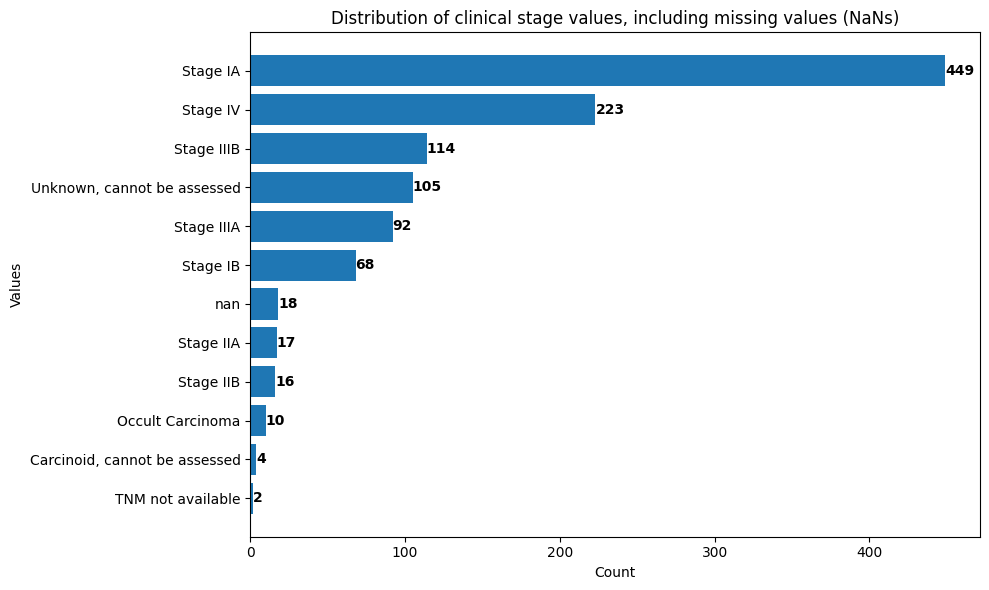

In [15]:
# plot histogram of values in nlst_clinical_df['clinical_stag_meaning'] by count,
# including NaN as a separate item
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'df' and the column is named 'column_name'

# Count values including NaNs
value_counts = with_images['clinical_stag_meaning'].value_counts(dropna=False)

# Create horizontal bar plot
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(value_counts.index.astype(str), value_counts.values)

# Add labels to the bars
for bar in bars:
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2, f'{width}',
            ha='left', va='center', fontweight='bold')

# Customize the plot
plt.title('Distribution of clinical stage values, including missing values (NaNs)')
plt.xlabel('Count')
plt.ylabel('Values')

# Adjust layout and display the plot
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()

To make this exploration a bit more involved, let's cross-tabulate the values of clinical and pathological stage!

Similar to how we post-processed clinical stage codes, we can apply the same steps to map `path_stag` - pathology stage - to human-readable meanings.

In [16]:
path_stag_values = nlst_clinical_data_columns[nlst_clinical_data_columns['column']=='path_stag']['values'].values[0]
path_stag_values

array([{'option_code': '.M', 'option_description': 'Missing'},
       {'option_code': '110', 'option_description': 'Stage IA'},
       {'option_code': '120', 'option_description': 'Stage IB'},
       {'option_code': '210', 'option_description': 'Stage IIA'},
       {'option_code': '220', 'option_description': 'Stage IIB'},
       {'option_code': '310', 'option_description': 'Stage IIIA'},
       {'option_code': '320', 'option_description': 'Stage IIIB'},
       {'option_code': '400', 'option_description': 'Stage IV'},
       {'option_code': '888', 'option_description': 'TNM not available'},
       {'option_code': '900', 'option_description': 'Occult Carcinoma'},
       {'option_code': '994', 'option_description': 'Carcinoid, cannot be assessed'},
       {'option_code': '999', 'option_description': 'Unknown, cannot be assessed'}],
      dtype=object)

In [19]:
# First, create a dictionary from the array of dictionaries
mapping_dict = {item['option_code']: item['option_description'] for item in path_stag_values}

# Create the new column 'X_descriptions' using map function
with_images['path_stag_meaning'] = with_images['path_stag'].astype(str).map(mapping_dict)

Now that we have clinical and pathology stage at patient level, we can make a plot cross-tabulating these two staging approaches.

In [20]:
import plotly.express as px

counts = with_images.groupby(["path_stag_meaning", "clinical_stag_meaning"]).size().reset_index(name='count')

fig = px.scatter(counts, x='path_stag_meaning', y='clinical_stag_meaning', size='count',
                 hover_data=['count'], color='count',
                 labels={'path_stag_meaning': 'Pathological Stage Meaning',
                         'clinical_stag_meaning': 'Clinical Stage Meaning',
                         'count': 'Count'},
                 title='Scatter Plot of Pathological vs Clinical Stage Meanings')

fig.update_traces(marker=dict(sizemin=5))
fig.update_layout(
    xaxis_title='Pathological Stage Meaning',
    yaxis_title='Clinical Stage Meaning',
    xaxis_tickangle=-45
)

fig.show()

## Connecting clinical data with the images

Now that we have the summary, wouldn't it be interesting to sample images corresponding to the different stages of the disease?

Fortunately, this is not only interesting, but also rather easy with the functionality available in IDC.

As an example, let's select identifiers of the patients that have advanced "Stage IV" cancer (121786 is an interesting patient!).

In [21]:
clinical_stageIV_cases = with_images[with_images['clinical_stag_meaning']=='Stage IV']['dicom_patient_id']

clinical_stageIV_cases

/usr/local/lib/python3.10/dist-packages/google/colab/_reprs.py:217: FutureWarning:

Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.



,dicom_patient_id
1,217991
11,122390
16,122208
19,132043
23,206342
...,...
1106,111221
1108,203449
1109,206030
1110,114311


There are 223 patients in total that meet this selection. Given the selected patient identifiers, we can easily select the CT imaging studies available for those patients.

In [31]:
stageIV_CT_studies = pd.merge(c.index[c.index['Modality']=='CT'], clinical_stageIV_cases, left_on='PatientID', right_on='dicom_patient_id', how='inner')['StudyInstanceUID'].drop_duplicates().values

# first 10 of the StudyInstanceUIDs ...
stageIV_CT_studies[:10]

array(['1.3.6.1.4.1.14519.5.2.1.7009.9004.587315619135149595233994365221',
       '1.2.840.113654.2.55.88100293929737387335509961255477792249',
       '1.2.840.113654.2.55.284501947897549658768511614511154124739',
       '1.2.840.113654.2.55.86664680299066011289805597771811820986',
       '1.3.6.1.4.1.14519.5.2.1.7009.9004.219219944684013443736709467864',
       '1.3.6.1.4.1.14519.5.2.1.7009.9004.283191735393082145985095424169',
       '1.2.840.113654.2.55.185162168232329939255776825036725312455',
       '1.2.840.113654.2.55.314139515924373104302438456870346588403',
       '1.2.840.113654.2.55.317367612830512871212720313253245912393',
       '1.2.840.113654.2.55.167580079228661407599381770953760150276'],
      dtype=object)

Now that we have `StudyInstanceUID`, this is all we need to see the images! `idc-index` provides convenience function to build the URL to open those studies in the viewer.

In [25]:
import random

sample_study_url = c.get_viewer_URL(studyInstanceUID=random.choice(stageIV_CT_studies), viewer_selector="ohif_v3")

sample_study_url

'https://viewer.imaging.datacommons.cancer.gov/v3/viewer/?StudyInstanceUIDs=1.2.840.113654.2.55.40647384181936964225695523583723916172'

You can copy and open that URL in your browser, or you can also run the following cell that will open the selected study directly in the notebook output cell!

In [27]:
# view selected series only
from IPython.display import IFrame
IFrame(sample_study_url, width=1100, height=900)

## Summary

We hope you enjoyed this tutorial! If something didn't work as expected, if you have any feedback or suggestions of what should be added to this tutorial, please contact IDC support by sending email to support@canceridc.dev or posting your question on [IDC User forum](https://discourse.canceridc.dev).

## Acknowledgments

Imaging Data Commons has been funded in whole or in part with Federal funds from the National Cancer Institute, National Institutes of Health, under Task Order No. HHSN26110071 under Contract No. HHSN261201500003l.

If you use IDC in your research, please cite the following publication:

> Fedorov, A., Longabaugh, W. J. R., Pot, D., Clunie, D. A., Pieper, S. D., Gibbs, D. L., Bridge, C., Herrmann, M. D., Homeyer, A., Lewis, R., Aerts, H. J. W., Krishnaswamy, D., Thiriveedhi, V. K., Ciausu, C., Schacherer, D. P., Bontempi, D., Pihl, T., Wagner, U., Farahani, K., Kim, E. & Kikinis, R. _National Cancer Institute Imaging Data Commons: Toward Transparency, Reproducibility, and Scalability in Imaging Artificial Intelligence_. RadioGraphics (2023). https://doi.org/10.1148/rg.230180